In [ ]:
!pip install scikit-surprise lightfm scikit-optimize 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!unzip /content/drive/MyDrive/ml/vk_practice_21/archive.zip
!cp /content/drive/MyDrive/ml/vk_practice_21/{evaluator.py,metrics.py,df_helpers.py,lightfm_help.py} /content/

Archive:  /content/drive/MyDrive/ml/vk_practice_21/archive.zip
replace genome_scores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [31]:
from surprise import BaselineOnly, SVD, NormalPredictor, NMF
from surprise import accuracy, Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, LeaveOneOut, GridSearchCV
import pandas as pd
from evaluator import Evaluator
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import df_helpers
from lightfm import LightFM
import lightfm.evaluation
from lightfm_help import objective, patk_learning_curve
from sklearn.feature_extraction import DictVectorizer
from skopt import forest_minimize
import scipy.sparse as sp

import os

# Подготовка данных

In [3]:
df = pd.read_csv('rating.csv')
df.drop(columns=['timestamp'], inplace=True)
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


Оставляем только пользователей с 10 и больше оценками

In [4]:
df = df_helpers.threshold_interactions_df(df, 'userId', 'movieId', 10, 10)

Starting interactions info
Number of rows: 138493
Number of cols: 26744
Sparsity: 0.540%
Ending interactions info
Number of rows: 138493
Number of columns: 15451
Sparsity: 0.933%


In [5]:
print(f"Number of interactions: {len(df):,}")
print(f"Numer of unique users: {df['userId'].unique().size:,}")
print(f"NAN count:\n{df.isna().sum()}")

Number of interactions: 19,964,833
Numer of unique users: 138,493
NAN count:
userId     0
movieId    0
rating     0
dtype: int64


Ограничим датасет, чтобы он влезал в память при тренировке

In [6]:
df.drop(df[df['userId'] > 1000].index, inplace=True)
print(f"Numer of unique users: {df['userId'].unique().size:,}")
print(f"Number of interactions: {len(df):,}")

Numer of unique users: 1,000
Number of interactions: 150,496


count    150496.000000
mean          3.475086
std           1.092339
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

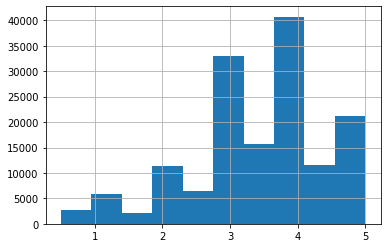

In [11]:
df['rating'].hist()
df['rating'].describe()

In [5]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df, reader=reader)

# Collaborative filtering

## Тренировка моделей

Будем сравнивать 4 алгоритма:


1. NormalPredictor - возвращает случайное значение, котрое сэмплится из нормального распределения
2. SVD - алгоритм SVD с параметрами по-умолчанию
3. SVD_tuned - алгоритм SVD, для которого были найдены оптимальные гиперпараметры
4. NMF - SVD-like алгоритм для матричного разложения


---

Выбранный метод разделения выборки для кросс-валидации - **LeaveOneOut** - оставляем последний interaction каждого пользователя для валидации. Является самым простым и робастным методом разделения выборки. Также является легко воспроизводимым.

Другим вариантом разделения выборки является **TemporalGloabalSplit**, когда для валидации мы оставляем вссе interaction'ы после определенной временной метки.


---

Метрики:
1. RMSE/MAE - отклонение предсказанной оценки от настоящей оценки
2. HitRate (MAP@k)- доля правильных рекомендаций для k предсказанных фильмов
3. 4-5 Star HitRate - доля правильно предсказанных фильмов, с рейтингом от 4 до 5
4. RankedHitRate - доля правильных предсказаний с учетом положения в предсказнном списке




In [13]:
param_grid = {'n_factors':[50,100,150],
              'n_epochs':[20,30],
              'lr_all':[0.005,0.01],
              'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
svd_tuned = gs.best_estimator['rmse']

In [14]:
eval = Evaluator(data)

eval.addModel(SVD(), 'SVD')
eval.addModel(svd_tuned, 'SVD_tuned')
eval.addModel(NMF(), 'NMF')
eval.addModel(NormalPredictor(), 'random')

preparing data...


In [15]:
eval.evaluateModel(doTopN=True)

Evaluating SVD
{'4-5HR': 0.031578947368421054,
 'HR': 0.02,
 'MAE': 0.7068215815327529,
 'RHR': 0.007335714285714286,
 'RMSE': 0.918052383395188}
Time: 130.13357210159302
-----------
Evaluating SVD_tuned
{'4-5HR': 0.01929824561403509,
 'HR': 0.011,
 'MAE': 0.6900771861773783,
 'RHR': 0.004083333333333333,
 'RMSE': 0.8940477951741962}
Time: 135.5979950428009
-----------
Evaluating NMF
{'4-5HR': 0.0,
 'HR': 0.0,
 'MAE': 0.7381443441625396,
 'RHR': 0.0,
 'RMSE': 0.9618225621164399}
Time: 104.50656747817993
-----------
Evaluating random
{'4-5HR': 0.005263157894736842,
 'HR': 0.005,
 'MAE': 1.1882322553001625,
 'RHR': 0.0028000000000000004,
 'RMSE': 1.4897816598208176}
Time: 85.81873893737793
-----------


Лучшие метрики у SVD и SVD_tuned. Однако, нужно заметить, что хотя SVD_tuned и показывает лучшие результаты на метриках RMSE и MAE, но на метриках, указывающих на способность модели рекомендовать релевантные фильмы (HR, 4-5HR, RHR), SVD_tuned работает сильно хуже обычного SVD.

## Оценка статистической значимости

Для оценки статистической значимости проведем парный t-тест распределениями метрик SVD и NormalPredictor.
Нулевая гипотеза - между метриками двух моделей нет разницы, т.е. SVD показывает такие же результаты как и модель с рандомными предсказаниями.
Принмаемый уровень занчимости - 0.05

In [6]:
eval = Evaluator(data)
eval.addModel(SVD(), 'SVD')
eval.addModel(NormalPredictor(), 'random')

def calculate_metrics(models, metrics, n_iters):
    results = {name: {metric: [] for metric in metrics} for name in models}

    for i in range(n_iters):
        for model in models:
            print(f'Evaluating {model}: {i} iter')
            res = eval.eval_10_fold(model)
            for metric in metrics:
                results[model][metric].extend(res[metric])

    return results


models = ['SVD', 'random']
metrics = ['RMSE', 'MAE', 'HR', '4-5HR', 'RHR']
results = calculate_metrics(models, metrics, 3)

preparing data...


0it [00:00, ?it/s]

Evaluating SVD: 0 iter


10it [17:10, 103.04s/it]
0it [00:00, ?it/s]

Evaluating random: 0 iter


10it [14:23, 86.32s/it]
0it [00:00, ?it/s]

Evaluating SVD: 1 iter


10it [17:11, 103.19s/it]
0it [00:00, ?it/s]

Evaluating random: 1 iter


10it [14:58, 89.86s/it]
0it [00:00, ?it/s]

Evaluating SVD: 2 iter


10it [17:08, 102.86s/it]
0it [00:00, ?it/s]

Evaluating random: 2 iter


10it [14:25, 86.54s/it]


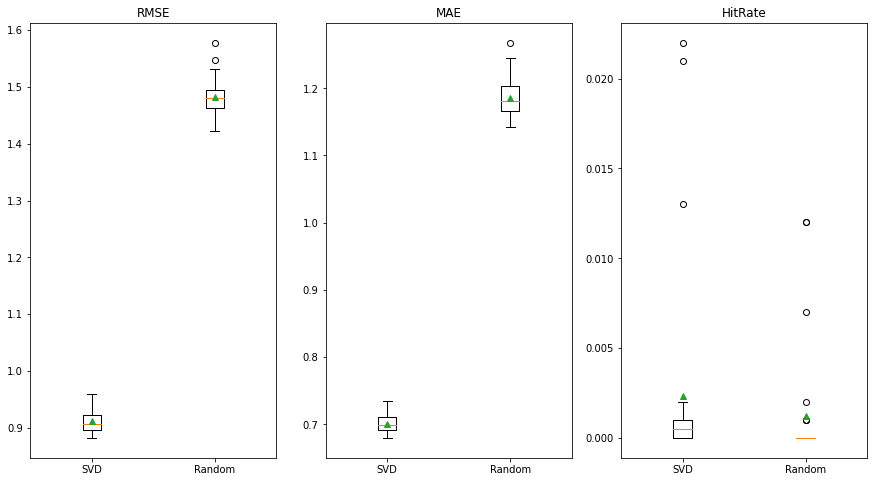

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.boxplot([results['SVD']['RMSE'], results['random']['RMSE']], labels=['SVD', 'Random'], showmeans=True)
ax1.set_title('RMSE')
ax2.boxplot([results['SVD']['MAE'], results['random']['MAE']], labels=['SVD', 'Random'], showmeans=True)
ax2.set_title('MAE')
ax3.boxplot([results['SVD']['HR'], results['random']['HR']], labels=['SVD', 'Random'], showmeans=True)
ax3.set_title('HitRate')
plt.show()

Полученные p-value

In [15]:
from scipy import stats
_, res_rmse = stats.ttest_rel(results['random']['RMSE'], results['SVD']['RMSE'])
_, res_hr = stats.ttest_rel(results['random']['HR'], results['SVD']['HR'])
_, res_4_5hr = stats.ttest_rel(results['random']['4-5HR'], results['SVD']['4-5HR'])

print(f"RMSE: {res_rmse:.3}\nHitRate: {res_hr:.3}\n4-5 HitRate: {res_4_5hr:.3}")

RMSE: 1.21e-37
HitRate: 0.0496
4-5 HitRate: 0.0366


По всем 3 метрикам p-value меньше принятого уровня значимости, значит мы можем отвергнуть нулевую гипотезу и сказать, что SVM и NormalPredictor показывают разные результаты. 

# Hybrid filtering

Подготовка данных

In [17]:
likes, uid_to_idx, idx_to_uid, mid_to_idx, idx_to_mid = df_helpers.df_to_matrix(df, 'userId', 'movieId')
train, test, user_index = df_helpers.train_test_split(likes, 5, 0.2)
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

## Датасет тэгов

Преобразуем информацию об имеющихся тегах в матрицу [фильмы X тэги]

In [18]:
df_tags = pd.read_csv('genome_scores.csv')
print(f"Number of unique tags: {df_tags['tagId'].unique().size}")

Number of unique tags: 1128


Отбросим тэги, relevance которых < 0.7 и фильмы, которых нет в обработанном датасете

In [19]:
df_tags.drop(df_tags[df_tags['relevance'] < 0.7].index, inplace=True)
df_tags.drop(df_tags[~df_tags['movieId'].isin(df['movieId'].unique())].index, inplace=True)

print(f"Number of unique tags: {df_tags['tagId'].unique().size}")

Number of unique tags: 1120


In [20]:
df_tags.groupby(['movieId']).tagId.count().describe()

count    8591.000000
mean       18.250378
std        13.486234
min         1.000000
25%         9.000000
50%        15.000000
75%        24.000000
max       110.000000
Name: tagId, dtype: float64

В среднем фильм описывается 13 тэгами.

---

Записываем тэги в матрицу фичей


In [21]:
feat_list = [{} for _ in idx_to_mid]

for _, row in df_tags.iterrows():
    feat_key = f'tag_{row.tagId}'
    idx = mid_to_idx.get(row.movieId)
    if idx is not None:
        feat_list[idx][feat_key] = 1

## Датасет жанров

Преобразуем информацию об имеющихся жанрах в матрицу [фильмы X жанры]

In [22]:
df_genre = pd.read_csv('movie.csv')
df_genre.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
df_genre.drop(df_genre[~df_genre['movieId'].isin(df['movieId'].unique())].index, inplace=True)

Добавляем информацию о жанрах в матрицу фичей

In [24]:
for _, row in df_genre.iterrows():
    genres = row.genres.split(sep='|')
    for genre in genres:
        feat_key = f'genre_{genre}'
        idx = mid_to_idx.get(row.movieId)
        if idx is not None:
            feat_list[idx][feat_key] = 1

Преобразуем нашу матрицу фичей в разреженную матрицу

In [25]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_list)
eye = sp.eye(item_features.shape[0], item_features.shape[0]).tocsr()
item_features = sp.hstack((eye, item_features))
item_features = item_features.tocsr().astype(np.float32)

## Обучение модели

LightFM модель с дефолтными параметрами без использования дополнительной матрицы фичей


In [26]:
model, train_patk, test_patk = patk_learning_curve(
    train, test, eval_train, num_epochs=100, k=10, fit_params={'num_threads': 4}
)

{}
+------------+------------+------------+
|   Epoch    |  train HR  |  test HR   |
+============+============+============+
|     10     |  0.50650   |  0.02700   |
+------------+------------+------------+
|     20     |  0.54800   |  0.02950   |
+------------+------------+------------+
|     30     |  0.57900   |  0.02900   |
+------------+------------+------------+
|     40     |  0.58500   |  0.03100   |
+------------+------------+------------+
|     50     |  0.60050   |  0.02950   |
+------------+------------+------------+
|     60     |  0.60400   |  0.03000   |
+------------+------------+------------+
|     70     |  0.60800   |  0.02950   |
+------------+------------+------------+
|     80     |  0.61150   |  0.02850   |
+------------+------------+------------+
|     90     |  0.60700   |  0.03000   |
+------------+------------+------------+
|    100     |  0.60300   |  0.03100   |
+------------+------------+------------+


Можно заметить, что мы добились HR в районе 0.03, что в 1.5 раза больше HR при использовании SVD


---

Подберем лучшие гиперпараметры


In [ ]:
space = [(50, 200), # epochs
         (10**-4, 10**-1, 'log-uniform'), # learning_rate
         (50, 120), # no_components
         (10**-5, 10**-1, 'log-uniform'), # alpha
        ]

results = forest_minimize(objective, space, n_calls=150,
                     random_state=42,
                     verbose=True)

print(results.x)

In [28]:
params = {
        'learning_rate': 0.023288879623320352,
        'no_components': 64,
        'user_alpha': 0.0009548326821494207,
        'item_alpha': 0.0009548326821494207
}

params_f = {
        'learning_rate': 0.06676184785227865,
        'no_components': 86,
        'item_alpha': 0.0005563892936299544
}

params_f['user_alpha'] = params_f['item_alpha']*0.6960826359109953

LightFM модель с оптимальными гиперпараметрами

In [29]:
model, train_patk, test_patk = patk_learning_curve(
    train, test, eval_train, num_epochs=170, k=10, fit_params = {'num_threads': 4}, model_params = params)

{'learning_rate': 0.023288879623320352, 'no_components': 64, 'user_alpha': 0.0009548326821494207, 'item_alpha': 0.0009548326821494207}
+------------+------------+------------+
|   Epoch    |  train HR  |  test HR   |
+============+============+============+
|     10     |  0.50150   |  0.02500   |
+------------+------------+------------+
|     20     |  0.53100   |  0.02700   |
+------------+------------+------------+
|     30     |  0.56350   |  0.02950   |
+------------+------------+------------+
|     40     |  0.59750   |  0.03100   |
+------------+------------+------------+
|     50     |  0.62150   |  0.03300   |
+------------+------------+------------+
|     60     |  0.63850   |  0.03500   |
+------------+------------+------------+
|     70     |  0.64450   |  0.03500   |
+------------+------------+------------+
|     80     |  0.65150   |  0.03650   |
+------------+------------+------------+
|     90     |  0.66250   |  0.03350   |
+------------+------------+------------+
|   

HR поднялся до 0.36 отностительно дефолтной модели LightFM


---

LightFM с оптимальными гиперпараметрами и использованием дополнительной матрицы фичей



In [38]:
model = LightFM(loss='warp',
                **params_f)
model.fit(train, epochs=100,
            num_threads=4, verbose=True, item_features=item_features
          )
metrics = lightfm.evaluation.precision_at_k(model, test,
                                            train_interactions=None,
                                            k=5, num_threads=4, item_features=item_features)
hit_rate = np.mean(metrics)
print(f"Avegage HitRate: {hit_rate}")

Avegage HitRate: 0.030991


Средний HitRate = 0.031. Добавление дополнительной и информации о фильмах не улучшило релевантность наших предсказаний отнотсительно baseline lightfm модели.